In [2]:
from pathlib import Path
from Bio.PDB import PDBList, PDBParser
import os
from tqdm import tqdm
import warnings
import pandas as pd
from Bio import SeqIO
from dotenv import load_dotenv
import os
import requests
import time
import json
from Bio.PDB.ic_rebuild import structure_rebuild_test
import numpy as np
import sys
import seaborn as sns
from Bio.Align import PairwiseAligner
import matplotlib.pyplot as plt

load_dotenv()
amino_acid_codes = json.load(open('amino_acid_codes.json'))

In [332]:
WINDOW_SIZE = 5
WINDOW_SIZE_CONTEXT = 6
PDBMINE_URL = os.getenv("PDBMINE_URL")
casp_protein_id = 'T1030'
casp_protein_id2 = 'T1030'
pdb_code = '6poo'
alphafold_id = f'{casp_protein_id}TS427_1'
outdir = Path(f'csvs/{casp_protein_id}_win{WINDOW_SIZE}-{WINDOW_SIZE_CONTEXT}')
if outdir.exists():
    print('Results already exist')
else:
    outdir.mkdir(exist_ok=False, parents=True)

In [4]:
def get_center(seq):
    if WINDOW_SIZE % 2 == 0:
        return seq[WINDOW_SIZE // 2 - 1]
    else:
        return seq[-WINDOW_SIZE // 2]
def get_seq(i):
    if WINDOW_SIZE % 2 == 0:
        if WINDOW_SIZE_CONTEXT % 2 == 0:
            return slice(i-WINDOW_SIZE//2+1,i+WINDOW_SIZE//2+1)
        return slice(i-WINDOW_SIZE//2,i+WINDOW_SIZE//2)
    else:
        return slice(i-WINDOW_SIZE//2,i+WINDOW_SIZE//2+1)
def get_seq_ctxt(i):
    if WINDOW_SIZE_CONTEXT % 2 == 0:
        return slice(i-WINDOW_SIZE_CONTEXT//2+1,i+WINDOW_SIZE_CONTEXT//2+1)
    return slice(i-WINDOW_SIZE_CONTEXT//2,i+WINDOW_SIZE_CONTEXT//2+1)
def get_subseq(seq):
    if WINDOW_SIZE % 2 == 0:
        return seq[WINDOW_SIZE_CONTEXT//2 - WINDOW_SIZE//2:WINDOW_SIZE_CONTEXT//2 + WINDOW_SIZE//2]
    else:
        if WINDOW_SIZE_CONTEXT % 2 == 0:
            return seq[WINDOW_SIZE_CONTEXT//2 - WINDOW_SIZE//2-1:WINDOW_SIZE_CONTEXT//2 + WINDOW_SIZE//2]
        return seq[WINDOW_SIZE_CONTEXT//2 - WINDOW_SIZE//2:WINDOW_SIZE_CONTEXT//2 + WINDOW_SIZE//2 + 1]

In [265]:
# Get X-ray pdb
pdbl = PDBList()
parser = PDBParser()
xray_fn = pdbl.retrieve_pdb_file(pdb_code, pdir='pdb', file_format='pdb', obsolete=False)

# Get CASP predictions
predictions_url = f'https://predictioncenter.org/download_area/CASP14/predictions/regular/{casp_protein_id}.tar.gz'
predictions_dir = Path(f'./casp-predictions/')
if not (predictions_dir / casp_protein_id).exists():
    predictions_dir.mkdir(exist_ok=True)
    os.system(f'wget -O {predictions_dir}/{casp_protein_id}.tar.gz {predictions_url}')
    os.system(f'tar -xvf {predictions_dir}/{casp_protein_id}.tar.gz -C {predictions_dir}')

# Get CASP results
results_url = 'https://predictioncenter.org/download_area/CASP14/results/tables/casp14.res_tables.T.tar.gz'
results_dir = Path('casp-results')
if not results_dir.exists():
    results_dir.mkdir(exist_ok=True)
    os.system(f'wget -O {results_dir / "casp14.res_tables.T.tar.gz"} {results_url}')
    os.system(f'tar -xvf {results_dir / "casp14.res_tables.T.tar.gz"} -C {results_dir}')
results_file = results_dir / f'{casp_protein_id2}.txt'
results = pd.read_csv(results_file, delim_whitespace=True)
results = results[results.columns[1:]]
results['Model'] = results['Model'].apply(lambda x: x.split('-')[0])

Structure exists: 'pdb/pdb6poo.ent' 


/tmp/ipykernel_3143388/2842285514.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  results = pd.read_csv(results_file, delim_whitespace=True)


In [6]:
# Check alignment of casp prediction and x-ray structure
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    record = next(iter(SeqIO.parse(xray_fn, "pdb-seqres")))
    print("Record id %s, chain %s" % (record.id, record.annotations["chain"]))
    # print(record.seq)
    print(len(record.seq))
    residue_chain = str(record.seq)#[residue_range[0]-1:residue_range[1]]
    print(residue_chain)

    pred_files = list((predictions_dir / casp_protein_id).iterdir())
    i=0
    print(pred_files[i].name)
    pred_seq = str(next(iter(SeqIO.parse(pred_files[i], "pdb-atom"))).seq)
    print(pred_seq)

    aligner = PairwiseAligner()
    aligner.mode = 'global'
    alignments =  aligner.align(residue_chain, pred_seq)

    print(alignments[0])
    print('Large matches:')
    for i,((t1,t2),(q1,q2)) in enumerate(zip(*alignments[0].aligned)):
        if t2-t1 > 5:
            print(f'Match of length: {t2-t1} residues at position t={t1}, q={q1}')

Record id 6POO:A, chain A
273
DQELGKQSRRSQDIIKSLGFLSSDQKDILVKSISSSKDSQLILKFVTQATQLNNAESTKAKQMAQNDVALIKNISPEVLEEYKEKIQRASTKSQVDEFVAEAKKVVNSNKETLVNQANGKKQEIAKLENLSNDEMLRYNTAIDNVVKQYNEGKLNITAAMNALNSIKQAAQEVAQKNLQKQYAKKIERISSKGLALSKKAKEIYEKHKSILPTPGYYADSVGTYLNRFRDKQTFGNRSVWTGQSGLDEAKKMLDEVKKLLKELQDLTRGTKED
T1030TS392_3
DQELGKQSRRSQDIIKSLGFLSSDQKDILVKSISSSKDSQLILKFVTQATQLNNAESTKAKQMAQNDVALIKNISPEVLEEYKEKIQRASTKSQVDEFVAEAKKVVNSNKETLVNQANGKKQEIAKLENLSNDEMLRYNTAIDNVVKQYNEGKLNITAAMNALNSIKQAAQEVAQKNLQKQYAKKIERISSKGLALSKKAKEIYEKHKSILPTPGYYADSVGTYLNRFRDKQTFGNRSVWTGQSGLDEAKKMLDEVKKLLKELQDLTRGTKED
target            0 DQELGKQSRRSQDIIKSLGFLSSDQKDILVKSISSSKDSQLILKFVTQATQLNNAESTKA
                  0 ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
query             0 DQELGKQSRRSQDIIKSLGFLSSDQKDILVKSISSSKDSQLILKFVTQATQLNNAESTKA

target           60 KQMAQNDVALIKNISPEVLEEYKEKIQRASTKSQVDEFVAEAKKVVNSNKETLVNQANGK
                 60 ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
que

# Collect Dihedrals - Xray and predictions

In [47]:
xray_structure = parser.get_structure(pdb_code, xray_fn)
xray_chain = list(xray_structure[0].get_chains())[0]

def get_phi_psi_for_structure(protein_structure, protein_id):
    protein_structure.atom_to_internal_coordinates(verbose=False)
    resultDict = structure_rebuild_test(protein_structure)
    if not resultDict['pass']:
        raise Exception('Failed to rebuild')
    residues = list(protein_structure.get_residues())
    phi_psi_ = []
    for i in range(WINDOW_SIZE_CONTEXT//2, len(residues) - WINDOW_SIZE_CONTEXT // 2):
        # Convert 3 char codes to 1 char codes
        seq = ''.join([amino_acid_codes.get(r.resname, 'X') for r in residues[get_seq(i)]])
        seq_ctxt = ''.join([amino_acid_codes.get(r.resname, 'X') for r in residues[get_seq_ctxt(i)]])
        # Get the center residue
        res = get_center(seq)
        if not residues[i].internal_coord:
            psi,phi = np.nan, np.nan
        else:
            psi = residues[i].internal_coord.get_angle("psi")
            phi = residues[i].internal_coord.get_angle("phi")
            psi = psi if psi else np.nan # if psi is None, set it to np.nan
            phi = phi if phi else np.nan # if phi is None, set it to np.nan
        phi_psi_.append([i, seq, seq_ctxt, res, phi, psi, xray_chain.id, protein_id])
    return phi_psi_

xray_phi_psi = get_phi_psi_for_structure(xray_chain, pdb_code)
xray_phi_psi = pd.DataFrame(xray_phi_psi, columns=['pos', 'seq', 'seq_ctxt', 'res', 'phi', 'psi', 'chain', 'protein_id'])
xray_phi_psi.to_csv(outdir / 'xray_phi_psi.csv', index=False)

In [48]:
# Get phi_psi's of each prediction
phi_psi_predictions_ = []
for prediction_pdb in tqdm((predictions_dir / casp_protein_id).iterdir()):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        prediction = parser.get_structure(prediction_pdb.name, prediction_pdb)
        try:
            chain = list(prediction[0].get_chains())[0]
            phi_psi_predictions_ += get_phi_psi_for_structure(chain, prediction.id)
        except Exception as e:
            print(e)
phi_psi_predictions = pd.DataFrame(phi_psi_predictions_, columns=['pos', 'seq', 'seq_ctxt', 'res', 'phi', 'psi', 'chain', 'protein_id'])
phi_psi_predictions.to_csv(outdir / 'phi_psi_predictions.csv', index=False)

13it [00:05,  2.39it/s]

Failed to rebuild


27it [00:11,  2.20it/s]

Failed to rebuild


41it [00:17,  2.30it/s]

Failed to rebuild


48it [00:20,  2.26it/s]

Failed to rebuild


51it [00:21,  2.23it/s]

Failed to rebuild


54it [00:23,  2.27it/s]

Failed to rebuild


55it [00:23,  2.28it/s]

Failed to rebuild


64it [00:27,  2.26it/s]

Failed to rebuild


69it [00:29,  2.31it/s]

Failed to rebuild


89it [00:38,  2.25it/s]

Failed to rebuild


93it [00:40,  2.29it/s]

Failed to rebuild


144it [01:02,  2.31it/s]

Failed to rebuild


159it [01:09,  2.60it/s]

Failed to rebuild


171it [01:14,  2.41it/s]

Failed to rebuild


210it [01:32,  2.14it/s]

Failed to rebuild


221it [01:37,  2.40it/s]

Failed to rebuild


240it [01:46,  2.27it/s]

Failed to rebuild


245it [01:48,  2.13it/s]

Failed to rebuild


283it [02:06,  2.12it/s]

Failed to rebuild


298it [02:12,  2.06it/s]

Failed to rebuild


303it [02:15,  2.10it/s]

Failed to rebuild


360it [02:41,  2.07it/s]

Failed to rebuild


364it [02:43,  2.09it/s]

Failed to rebuild


382it [02:51,  2.06it/s]

Failed to rebuild


412it [03:06,  2.04it/s]

Failed to rebuild


423it [03:11,  2.27it/s]

Failed to rebuild


459it [03:28,  2.15it/s]

Failed to rebuild


464it [03:31,  2.01it/s]

Failed to rebuild


469it [03:33,  1.99it/s]

Failed to rebuild


478it [03:37,  1.98it/s]

Failed to rebuild


479it [03:38,  2.32it/s]

Failed to rebuild


483it [03:40,  2.32it/s]

Failed to rebuild


501it [03:49,  2.19it/s]


# PDBMine

In [49]:
# Test connection
response = requests.get(PDBMINE_URL + f'/v1/api/protein/{pdb_code}', verify=False)
assert(response.ok)
protein_data = response.json()

In [31]:
# Get Phi-Psi distribution from PDBMine

def query_pdbmine(window_size):
    record = next(iter(SeqIO.parse(xray_fn, "pdb-seqres")))
    residue_chain = str(record.seq)

    code_length = 1
    broken_chains = []

    # break chain into sections of length 100 - for memory reasons
    # overlap by window_size-1
    for i in range(0, len(residue_chain), 100-window_size+1):
        broken_chains.append(residue_chain[i:i+100])

    match_outdir = outdir / f'matches-{window_size}'
    match_outdir.mkdir(exist_ok=False)

    for i,chain in enumerate(tqdm(broken_chains)):
        if len(chain) < window_size: # in case the last chain is too short
            continue

        response = requests.post(
            PDBMINE_URL + '/v1/api/query',
            json={
                "residueChain": chain,
                "codeLength": code_length,
                "windowSize": window_size
            }
        )
        assert(response.ok)
        print(response.json())
        query_id = response.json().get('queryID')
        assert(query_id)

        time.sleep(60)
        while(True):
            response = requests.get(PDBMINE_URL + f'/v1/api/query/{query_id}')
            if response.ok:
                matches = response.json()['frames']
                break
            else:
                print('Waiting')
                time.sleep(15)
        print(f'Received matches - {i}')
        json.dump(matches, open(match_outdir / f'matches-win{window_size}_{i}.json', 'w'), indent=4)
query_pdbmine(WINDOW_SIZE)
query_pdbmine(WINDOW_SIZE_CONTEXT)

  0%|          | 0/3 [00:00<?, ?it/s]

{'status': 'Running', 'queryID': '42934bbb-0d8f-11ef-8a9b-0242ac110002'}
Received matches - 0


 33%|███▎      | 1/3 [01:05<02:11, 65.85s/it]

{'status': 'Running', 'queryID': '69d3ee4a-0d8f-11ef-8a9b-0242ac110002'}
Received matches - 1


 67%|██████▋   | 2/3 [02:11<01:05, 65.97s/it]

{'status': 'Running', 'queryID': '91323476-0d8f-11ef-8a9b-0242ac110002'}
Received matches - 2


  0%|          | 0/3 [00:00<?, ?it/s]

{'status': 'Running', 'queryID': 'b83b0669-0d8f-11ef-8a9b-0242ac110002'}


 33%|███▎      | 1/3 [01:00<02:00, 60.09s/it]

Received matches - 0
{'status': 'Running', 'queryID': 'dc0b9497-0d8f-11ef-8a9b-0242ac110002'}


 67%|██████▋   | 2/3 [02:00<01:00, 60.09s/it]

Received matches - 1
{'status': 'Running', 'queryID': 'ffe0b558-0d8f-11ef-8a9b-0242ac110002'}


100%|██████████| 3/3 [03:00<00:00, 60.12s/it]

Received matches - 2


In [50]:
# Get phi-psi from PDBMine matches
# If any sequence appears twice, only take the first one bc the distribution is the same
def get_phi_psi_mined(window_size):
    seqs = []
    phi_psi_mined = []
    for matches in Path(outdir / f'matches-{window_size}').iterdir():
        matches = json.load(matches.open())
        for seq_win,v in matches.items():
            seq = seq_win[4:]
            if seq in seqs:
                continue
            seqs.append(seq)
            for protein,seq_matches in v.items():
                protein_id, chain = protein.split('_')
                if protein_id.lower() == pdb_code.lower(): # skip the protein we're looking at
                    continue
                for seq_match in seq_matches:
                    center_res = seq_match[window_size//2]
                    res, phi, psi = center_res.values()
                    phi_psi_mined.append([seq, res, phi, psi, chain, protein_id])
    phi_psi_mined = pd.DataFrame(phi_psi_mined, columns=['seq', 'res', 'phi', 'psi', 'chain', 'protein_id'])
    phi_psi_mined.to_csv(outdir / f'phi_psi_mined_win{window_size}.csv', index=False)
    return phi_psi_mined

phi_psi_mined = get_phi_psi_mined(WINDOW_SIZE)
phi_psi_mined_ctxt = get_phi_psi_mined(WINDOW_SIZE_CONTEXT)

# Results

In [7]:
phi_psi_mined = pd.read_csv(outdir / f'phi_psi_mined_win{WINDOW_SIZE}.csv')
phi_psi_mined_ctxt = pd.read_csv(outdir / f'phi_psi_mined_win{WINDOW_SIZE_CONTEXT}.csv')
phi_psi_predictions = pd.read_csv(outdir / 'phi_psi_predictions.csv')
xray_phi_psi = pd.read_csv(outdir / 'xray_phi_psi.csv')
overlapping_seqs = list(set(phi_psi_mined_ctxt.seq) & set(phi_psi_predictions.seq_ctxt) & set(xray_phi_psi.seq_ctxt))

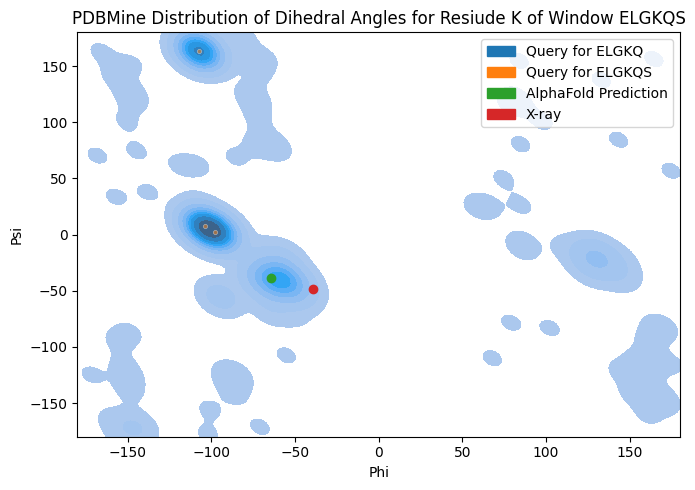

Max: P(-100.7799442896936, 4.5125348189415035)=0.0009155195299596092


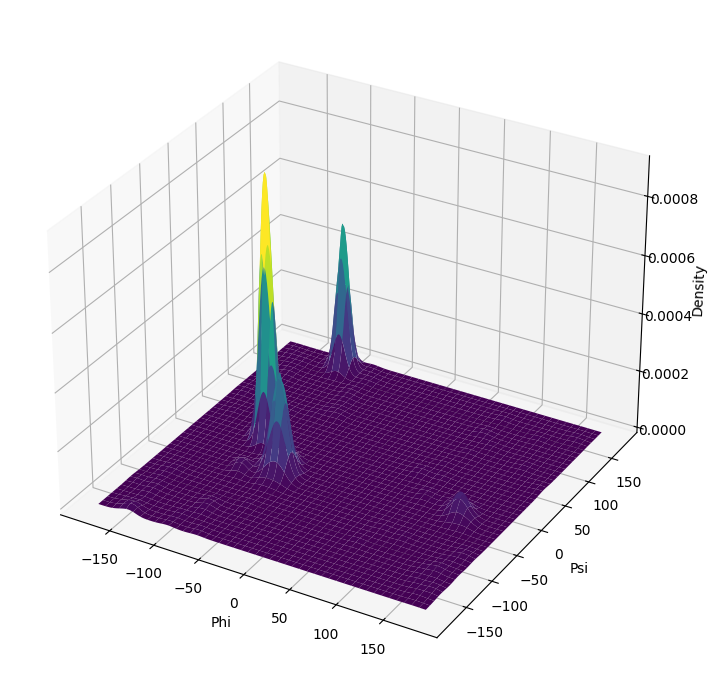

In [168]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import matplotlib.patches as mpatches

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

kdews = [1,128]
def plot_one_dist(seq, pred_id, pred_name=None, axlims=None, bw_method=None):
    pred_name = pred_name or pred_id
    inner_seq = get_subseq(seq)
    # inner_seq = seq[WINDOW_SIZE_CONTEXT // 2 - WINDOW_SIZE // 2:WINDOW_SIZE_CONTEXT // 2 + WINDOW_SIZE // 2 + 1]
    phi_psi_dist = phi_psi_mined[phi_psi_mined.seq == inner_seq].copy()
    phi_psi_ctxt_dist = phi_psi_mined_ctxt[phi_psi_mined_ctxt.seq == seq].copy()
    phi_psi_alpha = phi_psi_predictions[(phi_psi_predictions.protein_id == pred_id) & (phi_psi_predictions.seq_ctxt == seq)]
    xray_phi_psi_seq = xray_phi_psi[xray_phi_psi.seq_ctxt == seq]

    phi_psi_dist['weight'] = kdews[0]
    phi_psi_ctxt_dist['weight'] = kdews[1]
    phi_psi_dist = pd.concat([phi_psi_dist, phi_psi_ctxt_dist])

    fig, ax = plt.subplots(figsize=(7,5))
    # sns.jointplot(data=phi_psi_dist, x='phi', y='psi', kind='kde')
    sns.scatterplot(data=phi_psi_ctxt_dist, x='phi', y='psi', ax=ax, color=colors[1],zorder=5, alpha=0.5, marker='.')
    sns.kdeplot(data=phi_psi_dist, x='phi', y='psi', weights='weight', ax=ax, fill=True, color=colors[0], bw_method=bw_method)
    
    ax.plot(phi_psi_alpha.phi, phi_psi_alpha.psi, 'o', color=colors[2], label='AlphaFold Prediction', zorder=10)
    ax.plot(xray_phi_psi_seq.phi, xray_phi_psi_seq.psi, 'o', color=colors[3], label='X-ray', zorder=10)
    ax.legend(handles=[
        mpatches.Patch(color=colors[0], label=f'Query for {inner_seq}'),
        mpatches.Patch(color=colors[1], label=f'Query for {seq}'),
        mpatches.Patch(color=colors[2], label='AlphaFold Prediction'),
        mpatches.Patch(color=colors[3], label='X-ray')
    ])
    ax.set_title(f'PDBMine Distribution of Dihedral Angles for Resiude {seq[WINDOW_SIZE_CONTEXT//2]} of Window {seq}')

    ax.set_xlabel('Phi')
    ax.set_ylabel('Psi')

    if axlims:
        ax.set_xlim(axlims[0][0], axlims[0][1])
        ax.set_ylim(axlims[1][0], axlims[1][1])

    plt.tight_layout()
    plt.show()

def plot_one_dist_3d(seq, pred_id, pred_name=None, bw_method=None):
    inner_seq = get_subseq(seq)#seq[WINDOW_SIZE_CONTEXT // 2 - WINDOW_SIZE // 2:WINDOW_SIZE_CONTEXT // 2 + WINDOW_SIZE // 2 + 1]
    pred_name = pred_name or pred_id
    phi_psi_dist = phi_psi_mined[phi_psi_mined.seq == inner_seq].copy()
    phi_psi_ctxt_dist = phi_psi_mined_ctxt[phi_psi_mined_ctxt.seq == seq].copy()

    phi_psi_dist['weight'] = kdews[0]
    phi_psi_ctxt_dist['weight'] = kdews[1]
    phi_psi_dist = pd.concat([phi_psi_dist, phi_psi_ctxt_dist])

    x = phi_psi_dist[['phi','psi']].values.T
    weights = phi_psi_dist['weight'].values
    kde = gaussian_kde(x, weights=weights, bw_method=bw_method)

    x_grid, y_grid = np.meshgrid(np.linspace(-180, 180, 360), np.linspace(-180, 180, 360))
    grid = np.vstack([x_grid.ravel(), y_grid.ravel()])
    z = kde(grid).reshape(x_grid.shape)
    print(f'Max: P({grid[0,z.argmax()]}, {grid[1,z.argmax()]})={z.max()}')

    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x_grid, y_grid, z, cmap='viridis')
    ax.set_xlabel('Phi')
    ax.set_ylabel('Psi')
    ax.set_zlabel('Density')
    plt.tight_layout()
    plt.show()

seq = 'ELGKQS'#overlapping_seqs[9]
bw_method = 0.1
plot_one_dist(seq, alphafold_id, 'AlphaFold', axlims=((-180, 180), (-180, 180)), bw_method=bw_method)
plot_one_dist_3d(seq, alphafold_id, 'AlphaFold', bw_method=bw_method)

In [182]:
def find_phi_psi_c(phi_psi_dist, phi_psi_ctxt_dist, eps, bw_method, kdews):
    
    # combine with weights
    phi_psi_dist['weight'] = kdews[0]
    phi_psi_ctxt_dist['weight'] = kdews[1]
    phi_psi_dist = pd.concat([phi_psi_dist, phi_psi_ctxt_dist])

    # Cluster with DBSCAN
    clustering = DBSCAN(eps=eps, min_samples=3).fit(phi_psi_dist.values)
    phi_psi_dist['cluster'] = clustering.labels_

    # Find most probable cluster
    kernel = gaussian_kde(phi_psi_dist[['phi','psi']].T, weights=phi_psi_dist['weight'], bw_method=bw_method)
    most_likely = phi_psi_dist.iloc[kernel(phi_psi_dist[['phi', 'psi']].values.T).argmax()]
    phi_psi_dist['prob'] = kernel(phi_psi_dist[['phi', 'psi']].values.T)
    c = phi_psi_dist[phi_psi_dist.cluster != -1].groupby('cluster').sum(numeric_only=True)
    if c.shape[0] == 0:
        print('No clusters found, using entire dist')
        phi_psi_dist_c = phi_psi_dist
    else:
        phi_psi_dist_c = phi_psi_dist[phi_psi_dist.cluster == c.prob.idxmax()]

    return phi_psi_dist, phi_psi_dist_c, most_likely

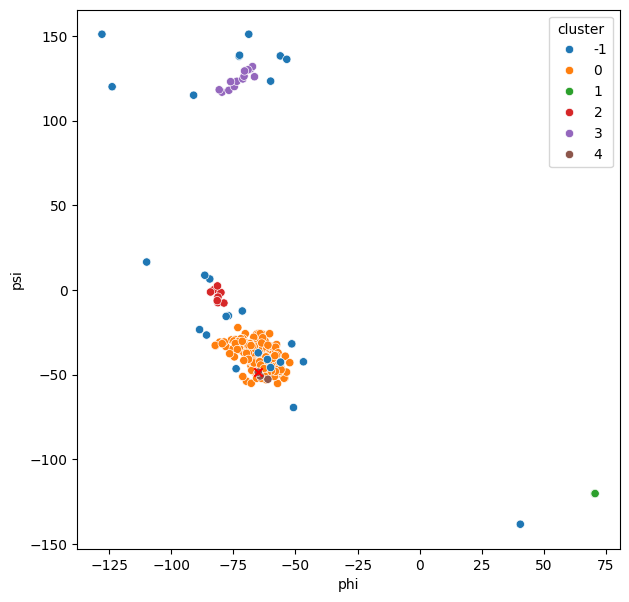

In [184]:
seq = overlapping_seqs[0]
inner_seq = get_subseq(seq)
phi_psi_dist = phi_psi_mined.loc[phi_psi_mined.seq == inner_seq][['phi','psi']].copy()
phi_psi_ctxt_dist = phi_psi_mined_ctxt.loc[phi_psi_mined_ctxt.seq == seq][['phi','psi']].copy()
phi_psi_dist, phi_psi_dist_c, most_likely = find_phi_psi_c(phi_psi_dist, phi_psi_ctxt_dist, eps, bw_method, kdews)

fig, ax = plt.subplots(figsize=(7,7))
sns.scatterplot(data=phi_psi_dist, x='phi', y='psi', hue='cluster', palette='tab10')
ax.scatter(most_likely.phi, most_likely.psi, marker='x', color='r')

QYAKK (36, 2)
QYAKKI (25, 2)
xray: 999.0917383748697
alpha: 526.1551255284935
preds:
                   0
count    410.000000
mean     730.989536
std     1862.065999
min       27.365047
25%      286.814531
50%      335.709889
75%      381.618232
max    15868.142474
{0: 33, 1: 19, -1: 5, 2: 4}


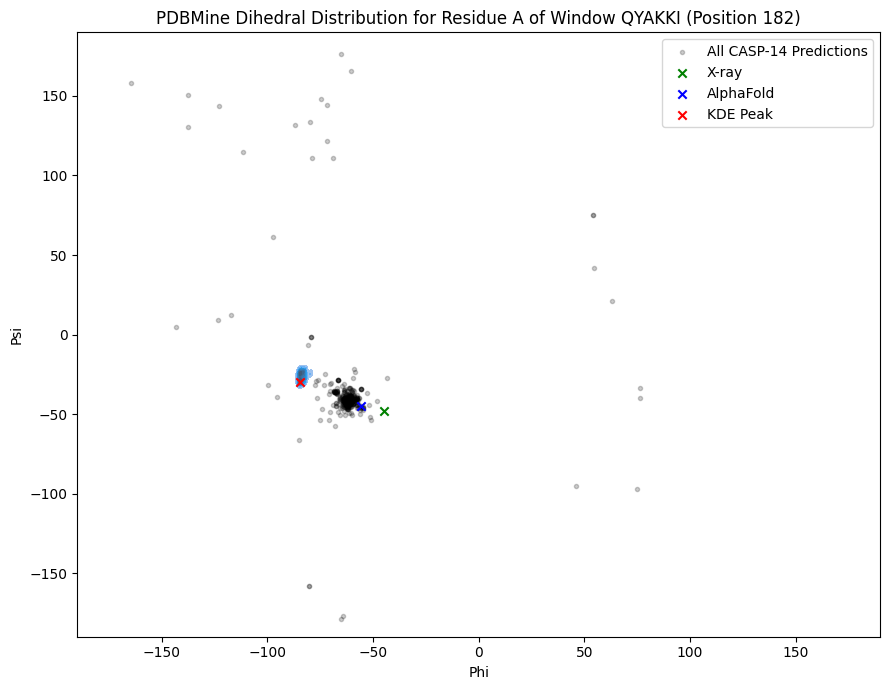

In [330]:
# For one window
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.neighbors import NearestNeighbors

bw_method = 0.1
kdews = [1,128]

def plot_clusters_for_window(seq, pred_id, pred_name=None, eps=10, axlims=None, zoom=False, zoom_lims=None):
    inner_seq = get_subseq(seq)
    pred_name = pred_name or pred_id
    phi_psi_dist = phi_psi_mined.loc[phi_psi_mined.seq == inner_seq][['phi','psi']].copy()
    phi_psi_ctxt_dist = phi_psi_mined_ctxt.loc[phi_psi_mined_ctxt.seq == seq][['phi','psi']].copy()
    print(inner_seq, phi_psi_dist.shape)
    print(seq, phi_psi_ctxt_dist.shape)

    phi_psi_dist, phi_psi_dist_c, most_likely = find_phi_psi_c(phi_psi_dist, phi_psi_ctxt_dist, eps, bw_method, kdews)
    phi_psi_c = phi_psi_dist_c[['phi','psi']].values

    # Mahalanobis distance to most common cluster
    cov = np.cov(phi_psi_c.T)
    icov = np.linalg.inv(cov)

    # xray
    xray = xray_phi_psi[xray_phi_psi.seq_ctxt == seq][['phi','psi']].values
    pos = xray_phi_psi[xray_phi_psi.seq_ctxt == seq]['pos'].values[0]
    md_xray = (xray - phi_psi_c.mean(axis=0)) @ icov @ (xray - phi_psi_c.mean(axis=0)).T

    # alphafold to most common cluster
    alpha = phi_psi_predictions[(phi_psi_predictions.protein_id == pred_id) & (phi_psi_predictions.seq_ctxt == seq)][['phi','psi']].values
    md_alpha = (alpha - phi_psi_c.mean(axis=0)) @ icov @ (alpha - phi_psi_c.mean(axis=0)).T

    # Other predictions
    preds = phi_psi_predictions[phi_psi_predictions.seq_ctxt == seq][['phi','psi']].values
    icov = np.repeat(np.expand_dims(icov, 0), preds.shape[0], axis=0) # expand for batch matrix multiplication
    md_preds = (np.expand_dims((preds - phi_psi_c.mean(axis=0)), 1) @ icov @ np.expand_dims((preds - phi_psi_c.mean(axis=0)), 2)).squeeze()
    print('xray:', md_xray[0,0])
    print('alpha:', md_alpha[0,0])
    print('preds:\n', pd.DataFrame(md_preds).describe())

    value_counts = phi_psi_dist.cluster.value_counts().sort_values(ascending=False)
    print(value_counts.to_dict())

    fig, ax = plt.subplots(figsize=(9,7))
    sns.kdeplot(data=phi_psi_dist_c, x='phi', y='psi', ax=ax, legend=False, fill=True)
    # ax.scatter(phi_psi_ctxt_dist.phi, phi_psi_ctxt_dist.psi, color='orange', marker='.', label=f'{seq} Query')
    ax.scatter(preds[:,0], preds[:,1], color='black', marker='.', alpha=0.2, label='All CASP-14 Predictions')
    ax.scatter(xray[0,0], xray[0,1], color='green', marker='x', label='X-ray')
    ax.scatter(alpha[0,0], alpha[0,1], color='blue', marker='x', label=pred_name)
    ax.scatter(most_likely.phi, most_likely.psi, color='red', marker='x', label='KDE Peak')

    ax.set_xlabel('Phi')
    ax.set_ylabel('Psi')
    res = phi_psi_predictions.loc[phi_psi_predictions.seq==inner_seq, 'res'].values[0]
    ax.set_title(f'PDBMine Dihedral Distribution for Residue {res} of Window {seq} (Position {pos})')
    ax.legend()
    if axlims:
        ax.set_xlim(axlims[0][0], axlims[0][1])
        ax.set_ylim(axlims[1][0], axlims[1][1])
    plt.tight_layout()
    plt.show()
seq = overlapping_seqs[3]
plot_clusters_for_window(seq, alphafold_id, 'AlphaFold', eps=5, axlims=((-190, 190), (-190, 190)))
# plot_clusters_for_window(seq, alphafold_id, 'AlphaFold', eps=10, zoom=True, zoom_lims=((-180, -10), (-100, 200)))

In [186]:
def get_md_for_all_predictions(eps=10, bw_method=None, kdews=None):
    kdews = kdews or [1,128]
    phi_psi_predictions['md'] = np.nan
    xray_phi_psi['md'] = np.nan
    for i,seq in enumerate(phi_psi_predictions.seq_ctxt.unique()):
        inner_seq = get_subseq(seq)
        phi_psi_dist = phi_psi_mined.loc[phi_psi_mined.seq == inner_seq][['phi','psi']]
        phi_psi_ctxt_dist = phi_psi_mined_ctxt.loc[phi_psi_mined_ctxt.seq == seq][['phi','psi']]
        print(f'{seq}: {phi_psi_dist.shape[0]} {phi_psi_ctxt_dist.shape[0]}')

        if phi_psi_ctxt_dist.shape[0] > 2:
            print('Enough context data for KDE - Using Full Context')
        if phi_psi_dist.shape[0] <= 2:
            print(f'Skipping {seq} - not enough data points')
            # leave as nan
            continue

        xray = xray_phi_psi[xray_phi_psi.seq_ctxt == seq][['phi','psi']].values
        preds = phi_psi_predictions.loc[phi_psi_predictions.seq_ctxt == seq][['phi','psi']].values
        print(xray.shape, preds.shape, phi_psi_dist.shape, phi_psi_ctxt_dist.shape)

        phi_psi_dist, phi_psi_dist_c, most_likely = find_phi_psi_c(phi_psi_dist, phi_psi_ctxt_dist, eps, bw_method, kdews)
        phi_psi_c = phi_psi_dist_c[['phi', 'psi']].values

        # Mahalanobis distance to most common cluster
        cov = np.cov(phi_psi_c.T)
        if np.linalg.det(cov) == 0:
            print(f'Skipping {seq} - singular matrix')
            # leave as nan
            continue
        icov = np.linalg.inv(cov)
        mean = phi_psi_c.mean(axis=0)

        md_xray = np.nan
        if xray.shape[0] > 0:
            # xray
            md_xray = (xray - mean) @ icov @ (xray - mean).T
            if np.any(md_xray < 0):
                md_xray = np.nan
            else:
                md_xray = np.sqrt(md_xray)[0,0]
            xray_phi_psi.loc[xray_phi_psi.seq_ctxt == seq, 'md'] = md_xray
        else:
            print(f'No xray seq {seq}')

        # All predictions
        if preds.shape[0] > 0:
            md = (np.expand_dims((preds - mean), 1) @ icov @ np.expand_dims((preds - mean), 2)).squeeze()
            if np.any(md < 0):
                md = np.nan
            else:
                md = np.sqrt(md)
            phi_psi_predictions.loc[phi_psi_predictions.seq_ctxt == seq, 'md'] = md
        else:
            print(f'No predictions seq {seq}')

    phi_psi_predictions.to_csv(outdir / f'phi_psi_predictions_md-eps{eps}.csv', index=False)
    xray_phi_psi.to_csv(outdir / f'xray_phi_psi_md-eps{eps}.csv', index=False)
        
eps=5
bw_method=0.1
kdews=[1,128]
get_md_for_all_predictions(eps, bw_method, kdews)

QELGKQ: 253 0
(0, 2) (462, 2) (253, 2) (0, 2)
No xray seq QELGKQ
ELGKQS: 258 3
Enough context data for KDE - Using Full Context
(1, 2) (462, 2) (258, 2) (3, 2)
LGKQSR: 56 0
(0, 2) (462, 2) (56, 2) (0, 2)
No xray seq LGKQSR
GKQSRR: 11 0
(1, 2) (467, 2) (11, 2) (0, 2)
No clusters found, using entire dist
KQSRRS: 47 0
(1, 2) (467, 2) (47, 2) (0, 2)
QSRRSQ: 132 0
(1, 2) (468, 2) (132, 2) (0, 2)
SRRSQD: 20 0
(0, 2) (469, 2) (20, 2) (0, 2)
No xray seq SRRSQD
RRSQDI: 6 0
(1, 2) (469, 2) (6, 2) (0, 2)
No clusters found, using entire dist
RSQDII: 42 1
(1, 2) (469, 2) (42, 2) (1, 2)
SQDIIK: 271 22
Enough context data for KDE - Using Full Context
(1, 2) (469, 2) (271, 2) (22, 2)
QDIIKS: 296 3
Enough context data for KDE - Using Full Context
(1, 2) (469, 2) (296, 2) (3, 2)
DIIKSL: 226 14
Enough context data for KDE - Using Full Context
(1, 2) (469, 2) (226, 2) (14, 2)
IIKSLG: 166 0
(0, 2) (469, 2) (166, 2) (0, 2)
No xray seq IIKSLG
IKSLGF: 189 31
Enough context data for KDE - Using Full Context
(1

In [301]:
eps=5
phi_psi_predictions = pd.read_csv(outdir / f'phi_psi_predictions_md-eps{eps}.csv')
xray_phi_psi = pd.read_csv(outdir / f'xray_phi_psi_md-eps{eps}.csv')

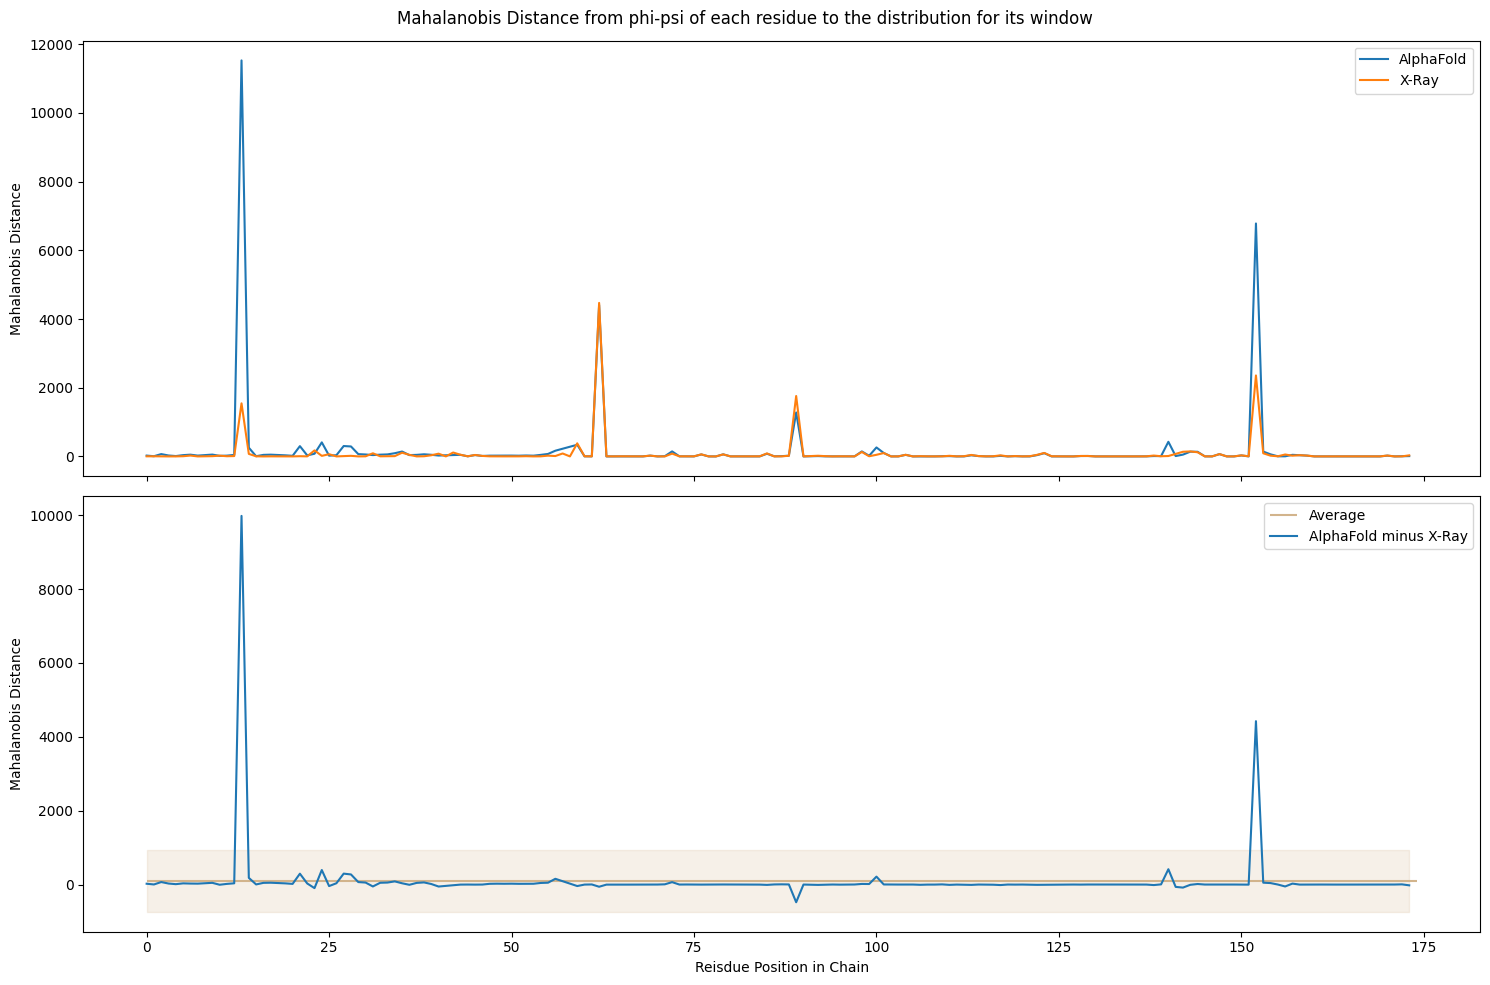

In [312]:
# Plot xray vs prediction md for each residue of one prediction
def filter(df):
    # return df[df.md > df.md.quantile(.9)]
    return df

def plot_res_vs_md(pred_id, pred_name=None, highlight_res=None):
    pred_name = pred_name or pred_id
    phi_psi_predictions['Source'] = 'CASP Prediction'
    phi_psi_predictions.loc[phi_psi_predictions.protein_id == pred_id, 'Source'] = pred_name
    alpha = phi_psi_predictions.loc[phi_psi_predictions.protein_id == pred_id]
    xray_phi_psi['Source'] = 'X-Ray'
    # alpha = alpha[alpha.md < alpha.md.quantile(.9)]
    # xray_phi_psi[xray_phi_psi.md < xray_phi_psi.md.quantile(.9)]
    both = pd.merge(alpha, xray_phi_psi, how='inner', on=['seq','seq'], suffixes=('_alpha','_xray'))
    both['md_diff'] = both['md_alpha'] - both['md_xray']
    fig, axes = plt.subplots(2, figsize=(15,10), sharex=True)
    sns.lineplot(data=both.reset_index(), x='index', y='md_alpha', ax=axes[0], label=pred_name)
    sns.lineplot(data=both.reset_index(), x='index', y='md_xray', ax=axes[0], label='X-Ray')
    axes[0].set_ylabel('Mahalanobis Distance')
    axes[1].hlines(both['md_diff'].mean(), xmin=0, xmax=len(both), color='tan', label='Average')
    axes[1].fill_between(x=both.index, y1=both['md_diff'].mean() + both['md_diff'].std(), y2=both['md_diff'].mean() - both['md_diff'].std(), color='tan', alpha=0.2)
    sns.lineplot(data=both.reset_index(), x='index', y='md_diff', ax=axes[1], label=f'{pred_name} minus X-Ray')
    axes[1].set_ylabel('Mahalanobis Distance')
    axes[1].set_xlabel('Reisdue Position in Chain')
    fig.suptitle('Mahalanobis Distance from phi-psi of each residue to the distribution for its window')
    plt.tight_layout()

    if highlight_res:
        for ax in axes:
            ax.axvspan(highlight_res[0], highlight_res[1], color='red', alpha=0.2)
    
    return both

protein_ids = phi_psi_predictions.protein_id.unique()
both = plot_res_vs_md(protein_ids[2], pred_name="AlphaFold")
# NOTE: for presentation, highlight area around res-300 to show this is where alphafold did bad

R-squared: 0.280918


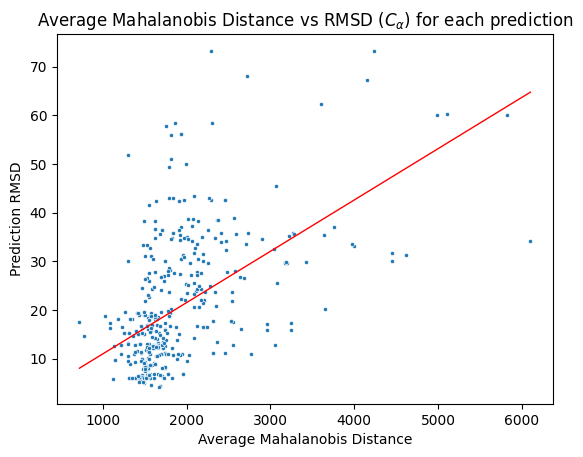

In [272]:
# Compare rmsd and mahalanobis distance
import matplotlib.pyplot as plt
from scipy.stats import linregress

def filter_and_sum(series):
    series = series[series < series.quantile(0.80)]
    return series.sum()

def plot_md_vs_rmsd(rmsd_lim=np.inf, md_lim_low=0, md_lim=np.inf):
    group_maha = phi_psi_predictions.groupby('protein_id', as_index=False).agg({'md': filter_and_sum})
    group_maha = group_maha.merge(results[['Model', 'RMS_CA']], left_on='protein_id', right_on='Model', how='inner')
    group_maha = group_maha[(group_maha.RMS_CA < rmsd_lim) & (group_maha.md > md_lim_low) & (group_maha.md < md_lim)].dropna()

    fig, ax = plt.subplots()
    sns.scatterplot(data=group_maha, x='md', y='RMS_CA', ax=ax, marker='.', legend=False)
    sns.regplot(data=group_maha, x='md', y='RMS_CA', ax=ax, ci=False, scatter=False, color='red', line_kws={'lw':1}, label='Regression Line')
    ax.set_xlabel('Average Mahalanobis Distance')
    ax.set_ylabel('Prediction RMSD')
    ax.set_title(r'Average Mahalanobis Distance vs RMSD ($C_{\alpha}$) for each prediction')
    regr = linregress(group_maha.md, group_maha.RMS_CA)
    print(f"R-squared: {regr.rvalue**2:.6f}")
plot_md_vs_rmsd()
# ax.set_xlim((0.8,1.4))
# ax.set_ylim((0,6))

# Specific Cases

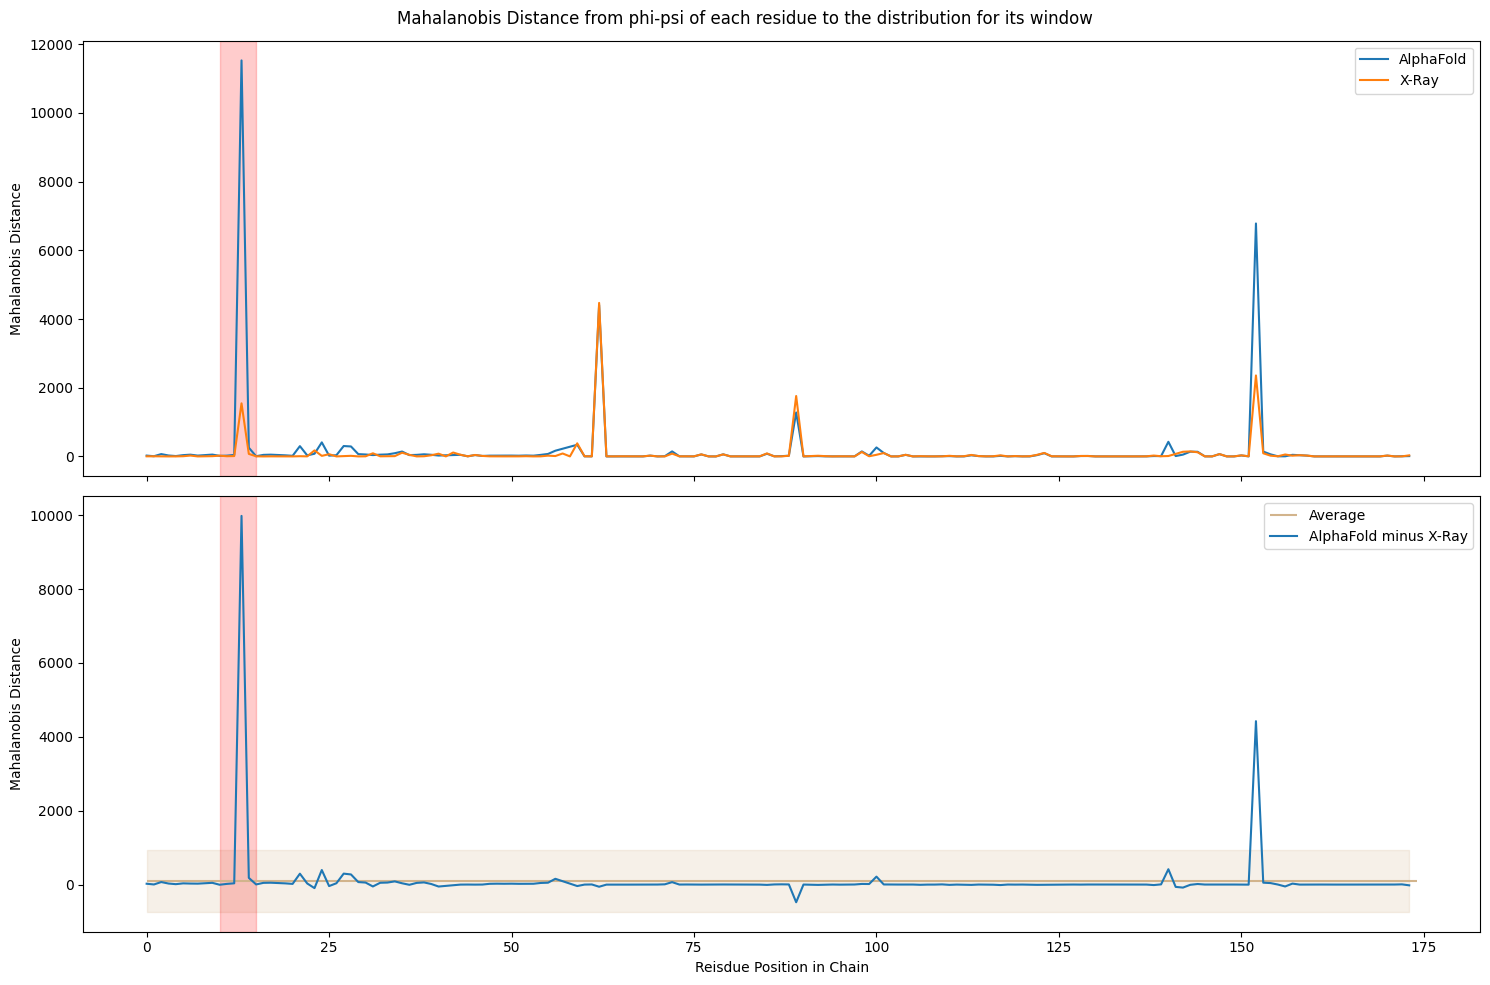

In [318]:
id = protein_ids[2]
both = plot_res_vs_md(id, pred_name="AlphaFold", highlight_res=(10,15))
highest = both.sort_values('md_diff', ascending=False).head(16)

GFLSS (81, 2)
GFLSSD (5, 2)
xray: 2388297.11706454
alpha: 132903900.25728258
preds:
                   0
count  4.500000e+02
mean   1.013187e+07
std    2.545015e+07
min    7.681554e+03
25%    1.039165e+06
50%    3.560991e+06
75%    9.996661e+06
max    3.257890e+08
{-1: 40, 0: 16, 1: 12, 2: 4, 4: 4, 6: 4, 3: 3, 5: 3}


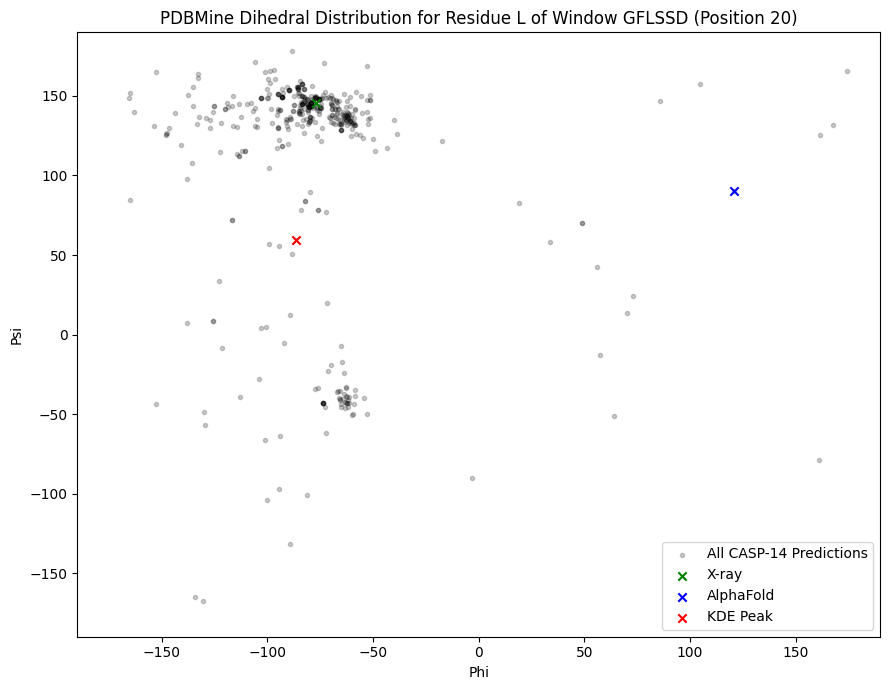

In [331]:
seq = highest.iloc[0].seq_ctxt_alpha
plot_clusters_for_window(seq, id, 'AlphaFold', eps=5, axlims=((-190, 190), (-190, 190)))

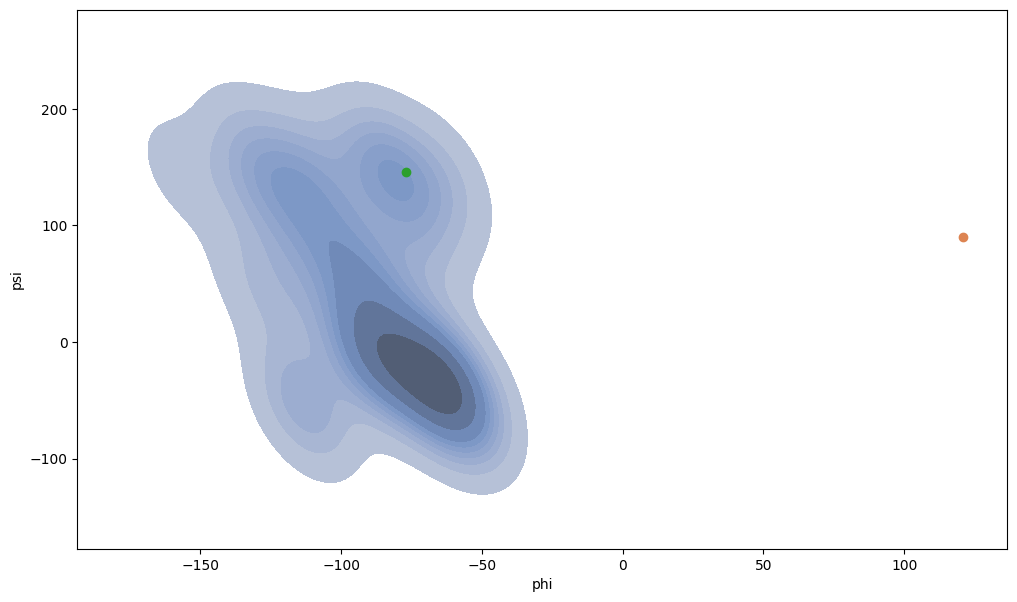

In [326]:
# plot dists with highest mahalanobis distance for alphafold
m = 0
fig, ax = plt.subplots(figsize=(12,7))
high = highest.iloc[0]
seq = high.seq_ctxt_alpha
xray_phi_psi_seq = xray_phi_psi[xray_phi_psi.seq_ctxt == seq]
phi_psi_alpha_seq = phi_psi_predictions[(phi_psi_predictions.protein_id==id) & (phi_psi_predictions.seq_ctxt == seq)]
phi_psi_dist = phi_psi_mined[phi_psi_mined.seq == get_subseq(seq)]

sns.kdeplot(data=phi_psi_dist, x='phi', y='psi', ax=ax, fill=True, color='#7490c0', legend=True)
ax.plot(phi_psi_alpha_seq.phi, phi_psi_alpha_seq.psi, 'o', color='#dd8452', label='Prediction')
ax.plot(xray_phi_psi_seq.phi, xray_phi_psi_seq.psi, 'o', color='tab:green', label='X-ray')